In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import deepcopy

RandomAffine => apply geometric changes on the image, like rotation and translation, that prevents the overfitting and make it simulates the real-world variations

transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])==> means the first list is the mean of RGB and second list is st.dev of RGB those numbers calculated from the ImageNet Dataset
Why normalization as we made already norm in ToTensor step?

1. ToTensor() Normalization
What it does:

Converts integer pixel values (0-255) to floating-point (0.0-1.0)

Changes data layout from (H,W,C) to (C,H,W)

Limitations:

Only does range scaling (255 → 1.0)

Doesn't center the data around zero

Doesn't account for channel-wise differences in distribution

2. Why Additional Normalize() is Needed
The extra normalization step provides three key benefits that ToTensor() alone doesn't:

A) Zero-Centering
Subtracts the mean (e.g., 0.485 for R channel)

Converts data from [0,1] to ~[-2,2] range

Why matters:

Helps avoid all-positive inputs that can cause zig-zagging gradient updates

Makes ReLU activations more effective (some inputs will be negative)

B) Channel-Specific Scaling
Divides by standard deviation (different per channel)

Example results after full normalization:

Dark pixel (R=0.1): (0.1-0.485)/0.229 ≈ -1.68

Bright pixel (R=0.9): (0.9-0.485)/0.229 ≈ 1.81

Why matters:

Compensates for natural differences between color channels

Red channel in nature tends to be brighter than blue

C) Variance Normalization
Makes all channels have similar "spread" of values

Without this:

Blue channel (std=0.225) would naturally vary less than red (std=0.229)

Network might over-emphasize high-variance channels

Practical Example
Consider two pixels after ToTensor():

Dark green: [0.2, 0.3, 0.1]

Bright red: [0.9, 0.4, 0.3]

After Normalize() (using ImageNet stats):

Dark green becomes: [-1.24, -0.70, -1.36]

Bright red becomes: [1.81, -0.25, -0.47]

Now the data:

Has zero mean

Similar variance across channels

Negative/positive balance


In [2]:
IMAGE_SIZE = 224

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomAffine(0,translate=(0.05,0.05)),#(degree of rot, translate)
    transforms.ColorJitter(brightness=0.2, contrast=0.2,saturation=0.2,hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform=transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
])

In [4]:
train_dataset=datasets.ImageFolder('/kaggle/input/chest-xray-pneumonia/chest_xray/train',transform=train_transform)


test_dataset=datasets.ImageFolder('/kaggle/input/chest-xray-pneumonia/chest_xray/test',transform=test_transform)

In [5]:
y_train=np.array(train_dataset.targets)

In [6]:
classes=np.unique(y_train)
classes

array([0, 1])

In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Check the data is balanced or not

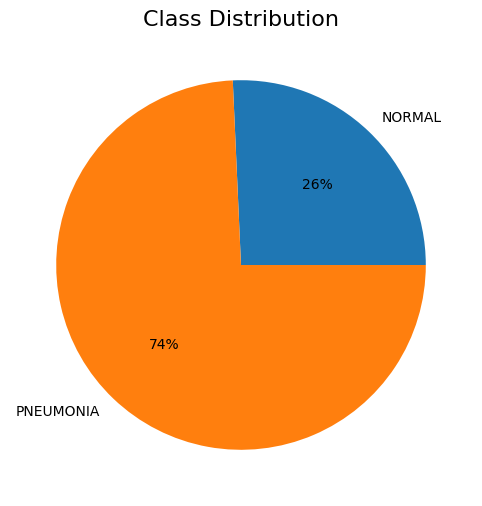

In [8]:
class_names = train_dataset.classes
freq = np.unique(y_train, return_counts = True)
plt.figure(figsize = (8, 6))
plt.title('Class Distribution', fontsize = 16)
plt.pie(freq[1], labels = class_names, autopct = '%1.0f%%')
plt.show()

In [9]:
# use compute class weights to overcome the issue of imbalanced data
class_weights=compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
#convert the balanced classes to torch
class_weights=torch.FloatTensor(class_weights).to(DEVICE)

print(f'Class weights: {class_weights}')

Class weights: tensor([1.9448, 0.6730], device='cuda:0')


this mean that the class 0 has fewer samples so we gave it more weight to make the model in training gives him more attention

and gives class 1 less weight bec it has many samples

In [10]:
train_loader = DataLoader(train_dataset,batch_size=48,shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset,batch_size=48,shuffle=False,num_workers=4)

In [11]:
print('Train Dataset:')
print('Number of images:', len(train_dataset))
print('Number of normal images:', np.sum(y_train == 0))
print('Number of pneumonia images:', np.sum(y_train == 1))

Train Dataset:
Number of images: 5216
Number of normal images: 1341
Number of pneumonia images: 3875


In [12]:
test_targets = np.array(test_dataset.targets)
print('Test Dataset:')
print('Number of images:', len(test_dataset))
print('Number of normal images:', np.sum(test_targets == 0))
print('Number of pneumonia images:', np.sum(test_targets == 1))

Test Dataset:
Number of images: 624
Number of normal images: 234
Number of pneumonia images: 390


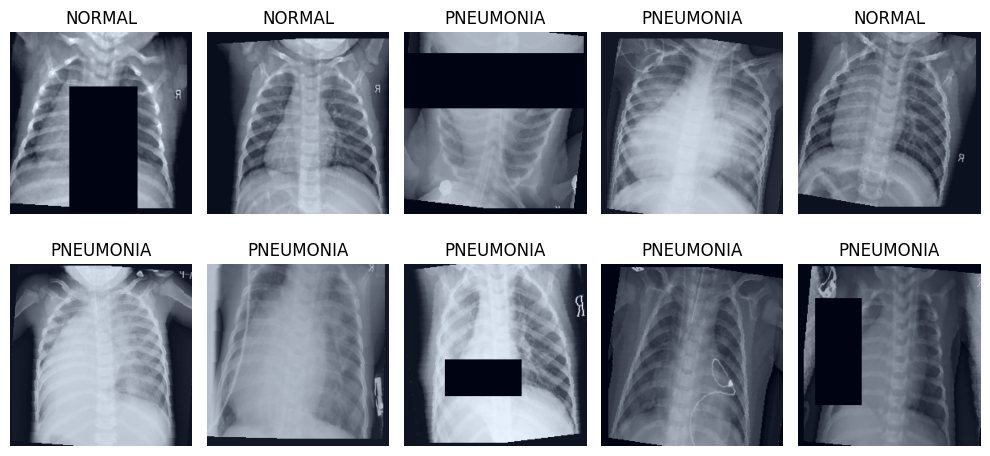

In [13]:
def show_samples(dataloader, num_samples=10):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        img = images[i].numpy()
        
        # Handle single-channel grayscale
        if img.shape[0] == 1:
            img = img.squeeze(0)  # Remove channel dim: (1,H,W) → (H,W)
        else:
            img = img.transpose((1, 2, 0))  # RGB: (C,H,W) → (H,W,C)
        
        # Denormalize
        mean = 0.485  # Use single value for grayscale
        std = 0.229
        img = (img * std) + mean
        img = np.clip(img, 0, 1)
        
        # Display grayscale with cmap='gray'
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(class_names[labels[i]])
    
    plt.tight_layout()
    plt.show()

show_samples(train_loader)

In [14]:
class XrayModel(nn.Module):
    def __init__(self,num_classes=2):
        super(XrayModel,self).__init__()
        self.mobilenet=mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

        # freeze base layers
        for param in self.mobilenet.parameters():
            param.requires_grad=False

        # unfreeze the last 4 layers
        for param in self.mobilenet.features[-4:].parameters():  
            param.requires_grad = True

        # extract the input dimensions
        num_features = self.mobilenet.classifier[1].in_features # last fc layer
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),  # Keep original dropout rate
            nn.Linear(num_features, num_classes)  # Direct to 2 classes
        )
        
        # Initialize the new classifier layer properly
        nn.init.xavier_normal_(self.mobilenet.classifier[1].weight)
        nn.init.zeros_(self.mobilenet.classifier[1].bias)
    
    def forward(self, x):
        return self.mobilenet(x)

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
               scheduler=None, num_epochs=5, patience=3, min_delta=0.01):
    best_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    # Early stopping variables
    epochs_no_improve = 0
    early_stop = False
    
    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping triggered!")
            break
            
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())
        
        # Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}')
        print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')
        
        # Check for improvement
        if epoch_acc > best_acc + min_delta:
            best_acc = epoch_acc
            best_model_wts = deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True
        
        # Step the scheduler if provided
        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(epoch_acc)
            else:
                scheduler.step()

    model.load_state_dict(best_model_wts)
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }
    
    return model, history

In [17]:
model = XrayModel().to(DEVICE)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(model.parameters(), lr = 1e-5, weight_decay = 0.001)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor = 0.5, patience = 2)
model, initial_history = train_model(model, 
                                     train_loader, 
                                     test_loader, 
                                     criterion, 
                                     optimizer, 
                                     scheduler,
                                     num_epochs=5)

Epoch 1/5:
Train Loss: 0.4635, Train Acc: 0.7707
Val Loss: 0.3661, Val Acc: 0.8494
Epoch 2/5:
Train Loss: 0.2599, Train Acc: 0.8855
Val Loss: 0.3064, Val Acc: 0.8894
Epoch 3/5:
Train Loss: 0.2111, Train Acc: 0.9135
Val Loss: 0.2902, Val Acc: 0.8926
Epoch 4/5:
Train Loss: 0.1785, Train Acc: 0.9281
Val Loss: 0.2873, Val Acc: 0.9006
Epoch 5/5:
Train Loss: 0.1676, Train Acc: 0.9344
Val Loss: 0.2895, Val Acc: 0.8974


In [18]:
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_predictions), np.array(all_probs)

In [19]:
y_true, y_pred, y_prob = evaluate_model(model, test_loader)

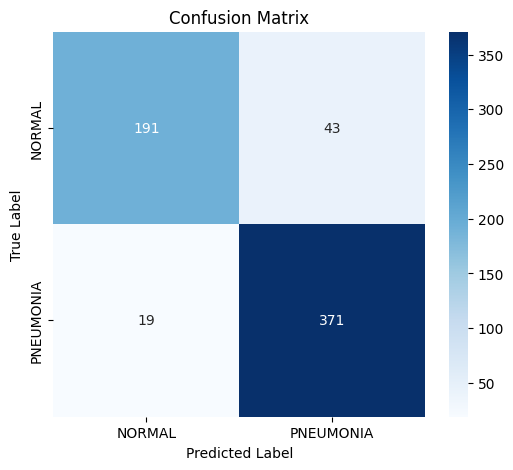

In [20]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.91      0.82      0.86       234
   PNEUMONIA       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



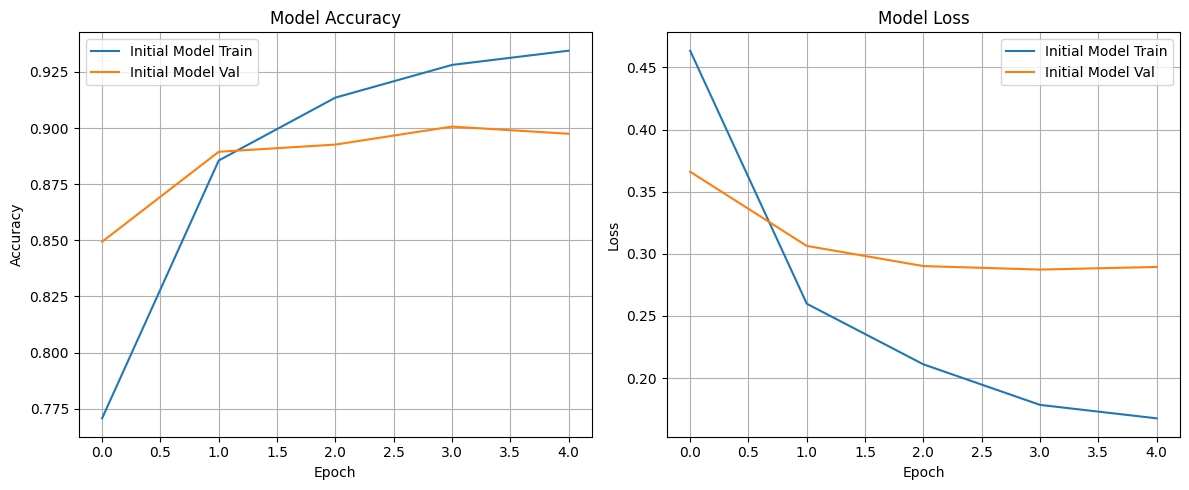

In [25]:
def plot_training_history(histories, labels):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for i, (hist, label) in enumerate(zip(histories, labels)):
        plt.plot(hist['train_acc'], label=f'{label} Train')
        plt.plot(hist['val_acc'], label=f'{label} Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    for i, (hist, label) in enumerate(zip(histories, labels)):
        plt.plot(hist['train_loss'], label=f'{label} Train')
        plt.plot(hist['val_loss'], label=f'{label} Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(
    [initial_history],
    labels=["Initial Model"]
)

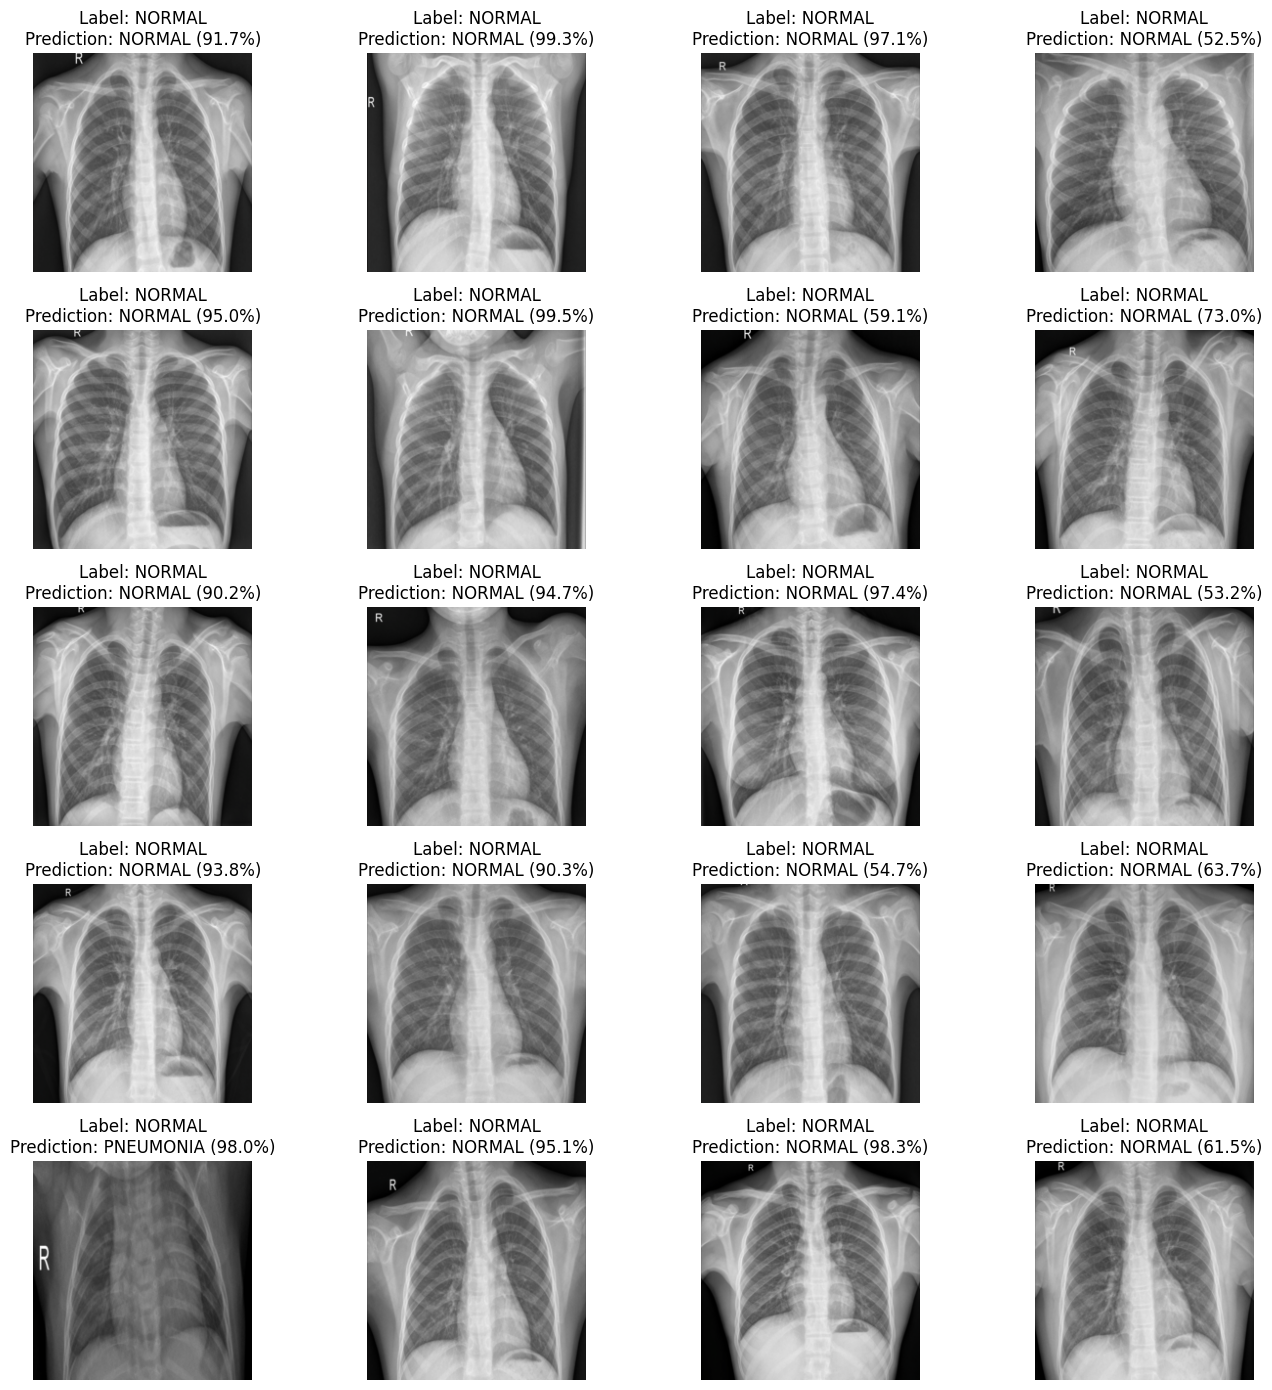

In [27]:
def show_predictions(model, dataloader, num_samples=20):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    probs = probs.cpu().numpy()
    
    plt.figure(figsize=[14, 14])
    for i in range(min(num_samples, len(images))):
        plt.subplot(5, 4, i+1)
        
        # Un-normalize for display
        img = images[i].transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.axis('off')
        true_label = class_names[labels[i]]
        predicted_label = class_names[preds[i]]
        confidence = 100 * np.max(probs[i])
        plt.title(f"Label: {true_label}\nPrediction: {predicted_label} ({confidence:.1f}%)")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader)

In [28]:
torch.save(model.state_dict(), 'pneumonia_model_pytorch.pth')
